<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction </b> </p>

In [1]:
# Importing necessary Libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import HDFStore,DataFrame
from pandas import read_hdf
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from matplotlib import rcParams
import math
import pickle
import os
from collections import Counter
import random
from tqdm import tqdm

#Convert to unix time
import time
import datetime

#Clustering
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from scipy.sparse.linalg import svds, eigs
import gc
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import networkx as nx
import pdb

In [2]:
if not os.path.isfile("/content/file.csv"):
    traincsv = pd.read_csv("/content/drive/MyDrive/train.csv")
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    
    # duplication check
    print("Number of duplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv("/content/file.csv",header=False,index=False)
    print("saved the graph into file")
else:
    g= nx.read_edgelist("/content/file.csv",delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


> Displaying a sub graph

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


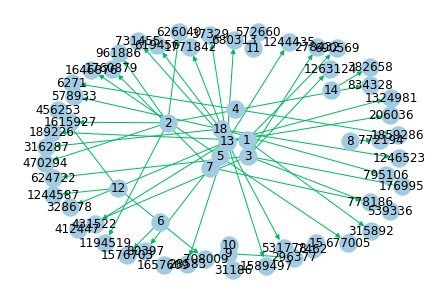

In [3]:
if not os.path.isfile("/content/file_sample.csv"):
    pd.read_csv("/content/drive/MyDrive/train.csv", nrows=50).to_csv('file_sample.csv', header= False, index= False)
    
subgraph= nx.read_edgelist('file_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

pos= nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_color='#A0CBE2', edge_color='#00bb5e', width= 1, edge_cmap= plt.cm.Blues, with_labels= True)
plt.savefig("graph_sample.pdf")

print(nx.info(subgraph))

# 1. Exploratory Data Analysis

In [4]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


## 1.1 No of followers for each person

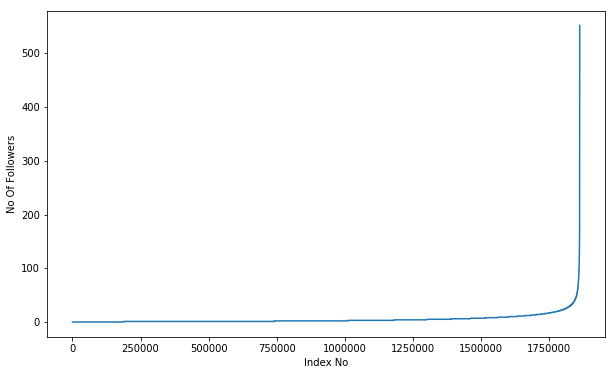

In [5]:
# in_degree => incoming edges
# g.in_degree() has tuples of index(node) as key and out_degree as values hence converted to dict,then to list and sorted.
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

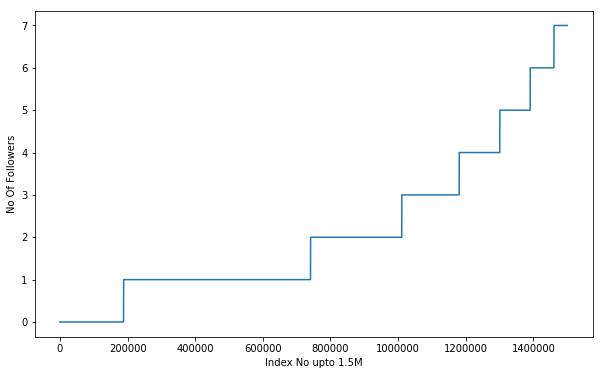

In [6]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))

# Zooming upto 1.5M indexes
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No upto 1.5M')
plt.ylabel('No Of Followers')
plt.show()

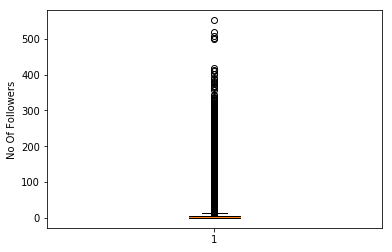

In [7]:
# Checking the outliers

plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [8]:
# 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


> 99% of data having only 40 followers.

In [9]:
### 99-100 percentile
for i in range(1,11):
    print(99+(i/10),'percentile value is',np.percentile(indegree_dist,99+(i/10)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


> 99.9 percentile of data having 112 followers and 100 percentile have nearly 552 followers.

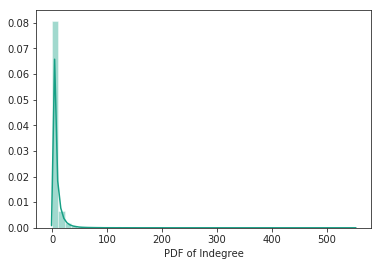

In [10]:
sns.set_style('ticks')
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
plt.show()

## 1.2 No of people each person is following

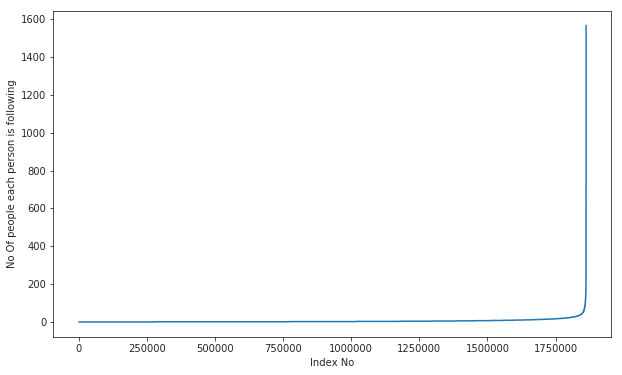

In [11]:
# out_degree => out going edges
# g.out_degree() has tuples of index(node) as key and out_degree as values hence converted to dict,then to list and sorted.
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

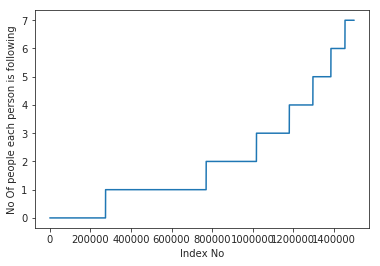

In [12]:
# Zooming upto 1.5M indexes
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

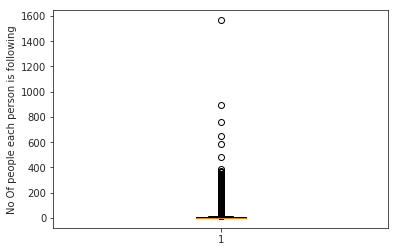

In [13]:
# Checking the outliers

plt.boxplot(outdegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

In [14]:
# 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [15]:
### 99-100 percentile
for i in range(1,11,1):
    print(99+(i/10),'percentile value is',np.percentile(outdegree_dist,99+(i/10)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


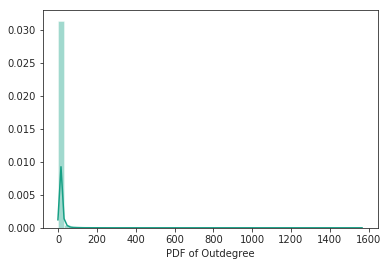

In [16]:
sns.set_style('ticks')
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
plt.show()

In [17]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist))

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [18]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [19]:
# for each node, if no predecessor and also if no successor then,
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are', count)

No of persons those are not not following anyone and also not having any followers are 0


## 1.3 Both Followers + Following

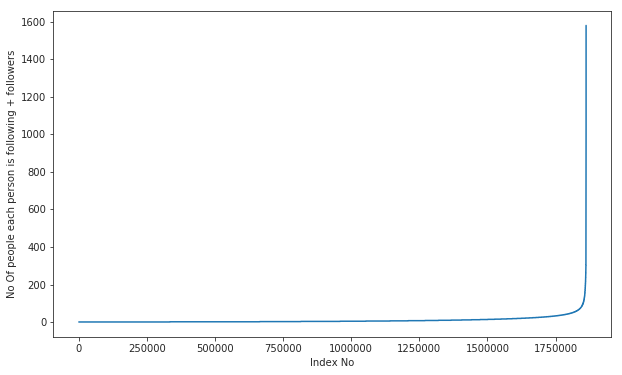

In [20]:
# 'd' contains all the dict of incoming and outgoing nodes.

d = Counter(dict(g.in_degree())) + Counter(dict(g.out_degree()))
in_out_degree = np.array(list(d.values()))

in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

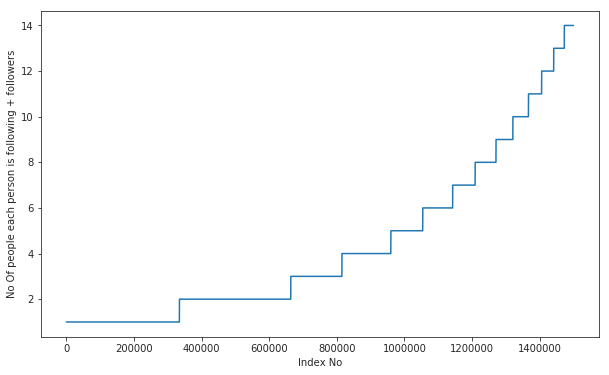

In [21]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [22]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [23]:
### 99-100 percentile
for i in range(1,11):
    print(99+(i/10),'percentile value is',np.percentile(in_out_degree_sort,99+(i/10)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [24]:
print('Min of no of followers + following = ',in_out_degree.min())
print('*'*50)
print('These many ',np.sum(in_out_degree == in_out_degree.min()),'persons are having minimum no of followers + following.')

Min of no of followers + following =  1
**************************************************
These many  334291 persons are having minimum no of followers + following.


In [25]:
print('Max of no of followers + following = ',in_out_degree.max())
print('*'*50)
print('These many',np.sum(in_out_degree == in_out_degree.max()),'persons are having maximum no of followers + following.')

Max of no of followers + following =  1579
**************************************************
These many 1 persons are having maximum no of followers + following.


In [26]:
print('These many',np.sum(in_out_degree<10),'persons are having followers + following less than 10.')

These many 1320326 persons are having followers + following less than 10.


In [27]:
print('No of weakly connected components:',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i) == 2:
        count += 1
print('Weakly connected components with 2 nodes:',count)

No of weakly connected components: 45558
Weakly connected components with 2 nodes: 32195


# 2. Posing a problem as classification problem 
## 2.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

In [28]:
###generating bad edges from given graph
if not os.path.isfile("/content/missing_edges_final.p"):
    #getting all set of edges
    r = csv.reader(open("/content/file.csv",'r'))
    # 9.43M edges of tuples in to dict format
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
    # create a set "missing_edges" which must contain the 0 labels
    missing_edges = set([])
    # must be less than 9.43M to generate in random from whopping '1.86M(1.86M - 1)' nodes to obtain 0 labelled connections
    while (len(missing_edges) < 9437519):
        # random node from 1.86M nodes
        ui= random.randint(1, 1862220)
        uj= random.randint(1, 1862220)
        # check for connection between nodes 'ui', 'uj' & if connection then check shortest path > 2, add them to 0 label
        tmp = edges.get((ui, uj), -1)
        if tmp == -1 and ui != uj:
            try:
                if nx.shortest_path_length(g, source= ui, target= uj) > 2:

                    missing_edges.add((ui, uj))
                else:
                    continue  
            except:  
                    missing_edges.add((ui, uj))              
        else:
            continue
    pickle.dump(missing_edges,open("/content/missing_edges_final.p",'wb'))
else:
    missing_edges = pickle.load(open("/content/missing_edges_final.p",'rb'))

CPU times: user 2.2 s, sys: 1.22 s, total: 3.42 s
Wall time: 4.16 s


In [29]:
len(missing_edges)

9437519

## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [30]:
if (not os.path.isfile('content/train_pos_after_eda.csv')) and \
(not os.path.isfile('content/test_pos_after_eda.csv')):
    
    #reading total data df
    df_pos = pd.read_csv('/content/drive/MyDrive/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links saperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)), 
                                                                         test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)), 
                                                                         test_size=0.2, random_state=9)
    
    print('*'*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('/content/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('/content/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('/content/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('/content/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Training data only 
    del missing_edges

In [31]:
if (os.path.isfile('content/train_pos_after_eda.csv')) and \
(os.path.isfile('content/test_pos_after_eda.csv')):        
    
    train_graph=nx.read_edgelist('content/train_pos_after_eda.csv', delimiter=',', create_using= nx.DiGraph(), 
                                 nodetype=int)
    test_graph=nx.read_edgelist('content/test_pos_after_eda.csv', delimiter=',', create_using= nx.DiGraph(), 
                                nodetype=int)
    
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())
    
    # intersection gives the common nodes in train and test after split
    print('No of people common in train and test -- ', len(train_nodes_pos.intersection(test_nodes_pos)))
    
    # sets are different hence we obtain people not in test data but in train data
    print('No of people present in train but not present in test -- ', len(train_nodes_pos - test_nodes_pos))

    # sets are different hence we obtain people not in train data but in test data and also in percentage. 
    print('No of people present in test but not present in train -- ', len(test_nodes_pos - train_nodes_pos))
    print('No of people not there in Train but exist in Test in total Test data are {} %'.format(
        len(test_nodes_pos - train_nodes_pos)/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
No of people common in train and test --  1063125
No of people present in train but not present in test --  717597
No of people present in test but not present in train --  81498
No of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


> we have a cold start problem here as the 81498 nodes info is not present in train data which accounts for 7%

In [32]:
#final train and test data sets

if (not os.path.isfile('/content/train_after_eda.csv')) and \
(not os.path.isfile('/content/test_after_eda.csv')) and \
(not os.path.isfile('/content/train_y.csv')) and \
(not os.path.isfile('/content/test_y.csv')) and \
(os.path.isfile('/content/train_pos_after_eda.csv')) and \
(os.path.isfile('/content/test_pos_after_eda.csv')) and \
(os.path.isfile('/content/train_neg_after_eda.csv')) and \
(os.path.isfile('/content/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('/content/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('/content/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('/content/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('/content/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('/content/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('/content/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('/content/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('/content/test_y.csv',header=False,index=False)

# Reading Data

In [33]:
X_train_pos = pd.read_csv('/content/train_after_eda.csv')
X_test_pos = pd.read_csv('/content/test_after_eda.csv')
y_train_pos = pd.read_csv('/content/train_y.csv')
y_test_pos = pd.read_csv('/content/test_y.csv')

print("Data points in train data", X_train_pos.shape)
print("Data points in test data", X_test_pos.shape)
print("Shape of target variable in train", y_train_pos.shape)
print("Shape of target variable in test", y_test_pos.shape)

Data points in train data (15100029, 2)
Data points in test data (3775007, 2)
Shape of target variable in train (15100029, 1)
Shape of target variable in test (3775007, 1)


In [34]:
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


## 2.1 Jaccard Distance:
    
\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [35]:
# u1 and u2 individually follows how many nodes
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [36]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [37]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [38]:
# how many nodes are individually following u1 and u2.
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [39]:
print(jaccard_for_followers(273084,470294))

0.0


In [40]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


## 2.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [41]:
# u1 and u2 individually follows how many nodes
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [42]:
print(cosine_for_followees(273084,1505602))

0.0


In [43]:
print(cosine_for_followees(273084,1635354))

0


In [44]:
# how many nodes are individually following u1 and u2.
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [45]:
print(cosine_for_followers(2,470294))

0.02886751345948129


In [46]:
print(cosine_for_followers(669354,1635354))

0


## 3. Ranking Measures


PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

## 3.1 Page Ranking


In [47]:
if not os.path.isfile('/content/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr, open('/content/page_rank.p','wb'))
else:
    pr = pickle.load(open('/content/page_rank.p','rb'))

In [48]:
print('PageRank Min:',pr[min(pr, key=pr.get)])
print('PageRank Max:',pr[max(pr, key=pr.get)])
print('PageRank Mean:',float(sum(pr.values())) / len(pr))

PageRank Min: 1.6556497245737814e-07
PageRank Max: 2.7098251341935827e-05
PageRank Mean: 5.615699699365892e-07


In [49]:
#for imputing to nodes which are not there in Train data (replacing into the 80k test data with mean value)
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699365892e-07


# 4. Other Graph Features

## 4.1 Shortest path:

Getting Shortest path between two nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 

In [50]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p= -1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        # no connected edges at all between nodes
        return -1

In [51]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [52]:
#testing
compute_shortest_path_length(669354,1635354)

-1

## 4.2 Checking for same community

In [53]:
#getting weakly connected edges from graph (weakly bcoz to check for community like college, school, workplace )

wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b) == -1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [54]:
belongs_to_same_wcc(861, 1659750)

0

In [55]:
belongs_to_same_wcc(669354,1635354)

0

## 4.3 Adamic/Adar Index:
Adamic / Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [56]:
# whether the node is celebrity or is just a common school mate/ work / college
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [57]:
calc_adar_in(1,189226)

0

In [58]:
calc_adar_in(669354,1635354)

0

## 4.4 Does a person follows back:

In [59]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [60]:
follows_back(1,189226)

1

In [61]:
follows_back(669354,1635354)

0

## 4.5 Katz Centrality:

 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$

In [62]:
if not os.path.isfile('/content/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('/content/katz.p','wb'))
else:
    katz = pickle.load(open('/content/katz.p','rb'))

In [63]:
print('Katz Centrality Min:',katz[min(katz, key=katz.get)])
print('Katz Centrality Max:',katz[max(katz, key=katz.get)])
print('Katz Centrality Mean:',float(sum(katz.values())) / len(katz))

Katz Centrality Min: 0.0007313532484065916
Katz Centrality Max: 0.003394554981699122
Katz Centrality Mean: 0.0007483800935504637


In [64]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935504637


## 4.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.


In [65]:
if not os.path.isfile('/content/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('/content/hits.p','wb'))
else:
    hits = pickle.load(open('/content/hits.p','rb'))

In [66]:
print('HITS Score Min:', hits[0][min(hits[0], key=hits[0].get)])
print('HITS Score Max:', hits[0][max(hits[0], key=hits[0].get)])
print('HITS Score Mean:', float(sum(hits[0].values())) / len(hits[0]))

HITS Score Min: 0.0
HITS Score Max: 0.004868653378780953
HITS Score Mean: 5.615699699353278e-07


# 5. Featurization
## 5. 1 Reading a sample of Data from both train and test

In [67]:
# Train data

filename ="/content/train_after_eda.csv"
if os.path.isfile(filename):
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1, n_train + 1), n_train - s))

In [68]:
# Test data

filename = "/content/test_after_eda.csv"
if os.path.isfile(filename):   
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1, n_test + 1), n_test - s))

In [69]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [70]:
# Preparing train and test dataframes

df_final_train = pd.read_csv('/content/train_after_eda.csv', skiprows=skip_train, 
                             names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('/content/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,1163878,1629981,1


In [71]:
df_final_test = pd.read_csv('/content/test_after_eda.csv', skiprows=skip_test,names=['source_node','destination_node'])
df_final_test['indicator_link'] = pd.read_csv('/content/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,1427585,1224220,1


## 5.2 Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [72]:
if not os.path.isfile('/content/storage_sample_stage1.h5'):
    
    # mapping jacca rd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda i:
                                            jaccard_for_followers(i['source_node'], i['destination_node']), axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda i:
                                            jaccard_for_followers(i['source_node'], i['destination_node']), axis=1)
 
    # mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda i:
                                            jaccard_for_followees(i['source_node'], i['destination_node']), axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda i:
                                            jaccard_for_followees(i['source_node'], i['destination_node']), axis=1)
    

    # mapping cosine followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda i:
                                            cosine_for_followers(i['source_node'], i['destination_node']), axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda i:
                                            cosine_for_followers(i['source_node'], i['destination_node']), axis=1)

    # mapping cosine followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda i:
                                            cosine_for_followees(i['source_node'], i['destination_node']), axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda i:
                                            cosine_for_followees(i['source_node'], i['destination_node']), axis=1)

In [73]:
def compute_features_stage1(df_final):
    
    # calculating no of followers and followees for source 's' and destination 'd'
    # calculating intersection of followers and followees for source and destination
    
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    
    for i, j in df_final.iterrows():
        try:
            s1= set(train_graph.predecessors(j['source_node']))
            s2= set(train_graph.successors(j['source_node']))
        except:
            s1= set()
            s2= set()
        try:
            d1= set(train_graph.predecessors(j['destination_node']))
            d2= set(train_graph.successors(j['destination_node']))
        except:
            d1= set()
            d2= set()
        
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [74]:
if not os.path.isfile('/content/storage_sample_stage1.h5'): # file doesn't has 'num_followers_d', hence composing
    
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('/content/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

else:

    df_final_train = read_hdf('/content/torage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf("/content/storage_sample_stage1.h5", 'test_df',mode='r')

In [75]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees'],
      dtype='object')

## 5.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [76]:
if not os.path.isfile("/content/storage_sample_stage2.h5"):
    
    #mapping adar index on train and test
    df_final_train['adar_index'] = df_final_train.apply(lambda i: 
                                                        calc_adar_in(i['source_node'], i['destination_node']), axis=1)
    df_final_test['adar_index'] = df_final_test.apply(lambda i: 
                                                      calc_adar_in(i['source_node'], i['destination_node']), axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train and test
    df_final_train['follows_back'] = df_final_train.apply(lambda i: 
                                                          follows_back(i['source_node'], i['destination_node']), axis=1)
    df_final_test['follows_back'] = df_final_test.apply(lambda i: 
                                                        follows_back(i['source_node'], i['destination_node']), axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train and test
    df_final_train['same_comp'] = df_final_train.apply(lambda i: 
                                                       belongs_to_same_wcc(i['source_node'], i['destination_node']), axis=1)
    df_final_test['same_comp'] = df_final_test.apply(lambda i: 
                                                     belongs_to_same_wcc(i['source_node'], i['destination_node']), axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train and test
    df_final_train['shortest_path'] = df_final_train.apply(lambda i: 
                                                           compute_shortest_path_length(i['source_node'],
                                                                                        i['destination_node']), axis=1)
    df_final_test['shortest_path'] = df_final_test.apply(lambda i: 
                                                         compute_shortest_path_length(i['source_node'], 
                                                                                      i['destination_node']), axis=1)

    hdf = HDFStore('/content/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

else:
    df_final_train = read_hdf('/content/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/content/storage_sample_stage2.h5', 'test_df',mode='r')

In [77]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path'],
      dtype='object')

## 5.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`Reference` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [78]:
#weight for source and destination of each link

Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:16<00:00, 110249.47it/s]


In [79]:
if not os.path.isfile('/content/storage_sample_stage3.h5'):
    
    #mapping to pandas train and test
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x, mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x, mean_weight_out))
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x, mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x, mean_weight_out))

    #some features engineerings on the in and out weights on train data
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights on test data
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [80]:
if not os.path.isfile('/content/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x: pr.get(x, mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x: pr.get(x, mean_pr))
    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x: pr.get(x, mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x: pr.get(x, mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x, mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x, mean_katz))
    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x, mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x, mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x, 0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x, 0))
    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x, 0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x, 0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x, 0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x, 0))
    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x, 0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x, 0))
    #================================================================================

    hdf = HDFStore('/content/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('/content/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/content/storage_sample_stage3.h5', 'test_df',mode='r')

In [81]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d'],
      dtype='object')

## 5.5 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [82]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [83]:
#for svd features to get feature vector creating a dict node val and index in svd vector

sadj_col = sorted(train_graph.nodes())
sadj_dict = { value:index for index, value in enumerate(sadj_col)}

In [84]:
Adj = nx.adjacency_matrix(train_graph, nodelist= sadj_col).asfptype()

In [85]:
U, s, V = svds(Adj, k = 6)

print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [86]:
if not os.path.isfile('/content/storage_sample_stage4.h5'):
    
    #===================================================================================================
    # Source and destination train for 'U'
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    # Source and destination train for 'V'
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    # Source and destination test for 'U'
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    # Source and destination test for 'V'
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('/content/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format= 'table', data_columns= True)
    hdf.put('test_df',df_final_test, format= 'table', data_columns= True)
    hdf.close()

In [87]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [88]:
len(df_final_train.columns)

55

In [89]:
y_train = df_final_train['indicator_link']
y_test = df_final_test['indicator_link']

In [90]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

# Random Forest
### Without Preferential Attachment and SVD

In [91]:
estimators = [10,50,100,250,450]

train_scores = []
test_scores = []

for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=5, max_features='auto', 
                                 max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                 min_samples_leaf=52, min_samples_split=120, min_weight_fraction_leaf=0.0, n_estimators=i, 
                                 n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train, y_train)
    
    y_pred_train = clf.predict(df_final_train)
    train_sc = f1_score(y_train, y_pred_train)
    
    y_pred_test = clf.predict(df_final_test)
    test_sc = f1_score(y_test, y_pred_test)
    
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    
    print('Estimators:',i,'Train Score:',train_sc,'test Score:',test_sc)


Estimators: 10 Train Score: 0.9269198879081435 test Score: 0.9193365048625437
Estimators: 50 Train Score: 0.9257276540139524 test Score: 0.9197594682983437
Estimators: 100 Train Score: 0.925826028320971 test Score: 0.9202034484941857
Estimators: 250 Train Score: 0.9239105275340362 test Score: 0.9181059903951471
Estimators: 450 Train Score: 0.923845377302936 test Score: 0.91791406134866


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

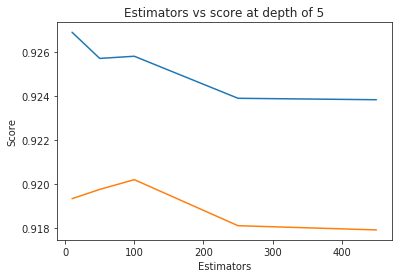

In [92]:
plt.plot(estimators, train_scores, label='Train Score')
plt.plot(estimators, test_scores, label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

In [93]:
depths = [3,9,11,15,20,35,50,70,130]

train_scores = []
test_scores = []

for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth= i, max_features='auto', 
                                 max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                 min_samples_leaf=52, min_samples_split=120, min_weight_fraction_leaf=0.0, n_estimators=250, 
                                 n_jobs=-1, random_state=25, verbose=0, warm_start=False)
    clf.fit(df_final_train, y_train)
    
    y_pred_train = clf.predict(df_final_train)
    train_sc = f1_score(y_train, y_pred_train)
    
    y_pred_test = clf.predict(df_final_test)
    test_sc = f1_score(y_test, y_pred_test)
    
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    
    print('Depths:',i,'Train Score:',train_sc,'test Score:',test_sc)


Depths: 3 Train Score: 0.8837393840610791 test Score: 0.8622905270469742
Depths: 9 Train Score: 0.9572870242303161 test Score: 0.9232974306009316
Depths: 11 Train Score: 0.9611820123228463 test Score: 0.9245350576044146
Depths: 15 Train Score: 0.9647720786104543 test Score: 0.925660178853235
Depths: 20 Train Score: 0.9648965446947304 test Score: 0.925505714947271
Depths: 35 Train Score: 0.9648620271358525 test Score: 0.925508850954556
Depths: 50 Train Score: 0.9648620271358525 test Score: 0.925508850954556
Depths: 70 Train Score: 0.9648620271358525 test Score: 0.925508850954556
Depths: 130 Train Score: 0.9648620271358525 test Score: 0.925508850954556


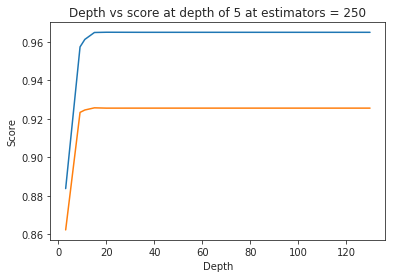

In [94]:
plt.plot(depths, train_scores, label='Train Score')
plt.plot(depths, test_scores, label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 250')
plt.show()

In [95]:
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)
skf = StratifiedKFold(n_splits= 5)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10 ,cv= skf, scoring='f1', random_state=25,
                               return_train_score= True)

rf_random.fit(df_final_train,y_train)

print('mean test scores', rf_random.cv_results_['mean_test_score'])

# return_train_score: boolean, default= False

print('mean train scores', rf_random.cv_results_['mean_train_score'])

mean test scores [0.96284045 0.96254949 0.95999826 0.9619557  0.96426847 0.96095504
 0.96031971 0.96256768 0.96202355 0.95882266]
mean train scores [0.96340597 0.96323411 0.96042792 0.96296677 0.96526832 0.96183264
 0.96097563 0.96346565 0.96282375 0.9590613 ]


In [96]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [97]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=14, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=28, 
                             min_samples_split=111, min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1, 
                             oob_score=False, random_state=25, verbose=0, warm_start=False)

clf.fit(df_final_train,y_train)

y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9662060724899659
Test f1 score 0.926357979116127


In [108]:
# Created my own function with slight changes
def confusionmatrix(a, b):
    
    c_m = confusion_matrix(a, b)
    precision = (c_m / c_m.sum(axis=0))
    recall = (c_m.T / c_m.sum(axis=0)).T
    
    plt.figure(figsize=(20,4))
    labels = [1,2]
    
    # representing Confusion Matrix in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(c_m, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    # representing Precision Matrix in heatmap format
    plt.subplot(1, 3, 2)
    sns.heatmap(precision, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    plt.subplot(1, 3, 3)
    
    # representing Recall Matrix in heatmap format
    sns.heatmap(recall, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


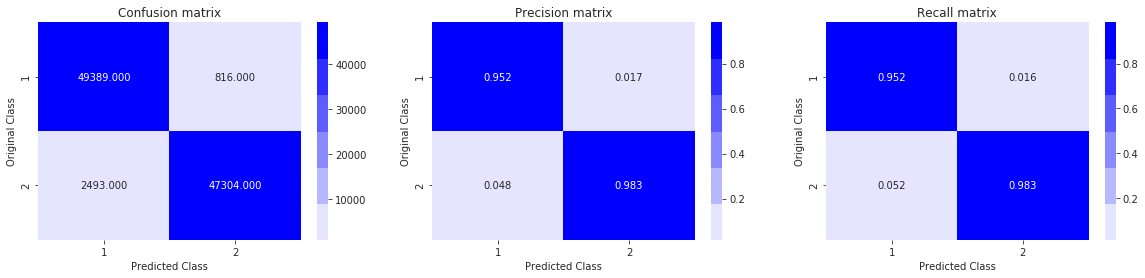

Test confusion_matrix


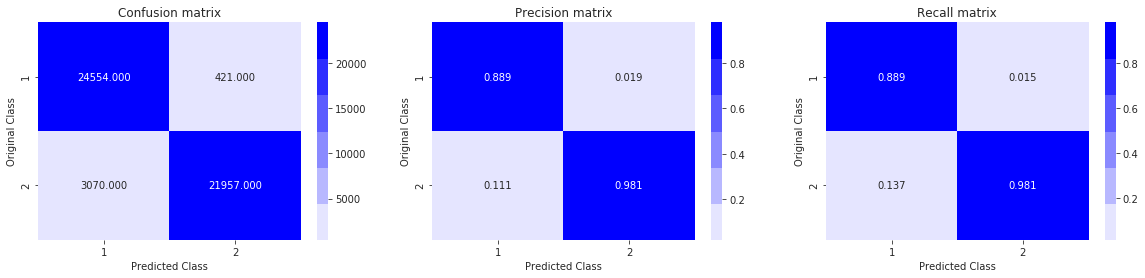

In [99]:
print('Train confusion_matrix')
confusionmatrix(y_train, y_train_pred)

print('Test confusion_matrix')
confusionmatrix(y_test, y_test_pred)

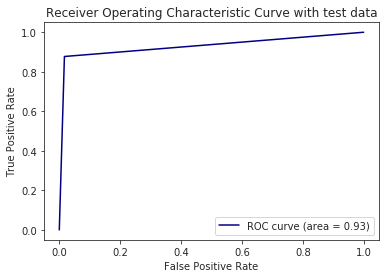

In [100]:

fpr, tpr, thresholds = roc_curve(y_test,y_test_pred)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, color='navy', label= 'ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve with test data')
plt.legend()
plt.show()

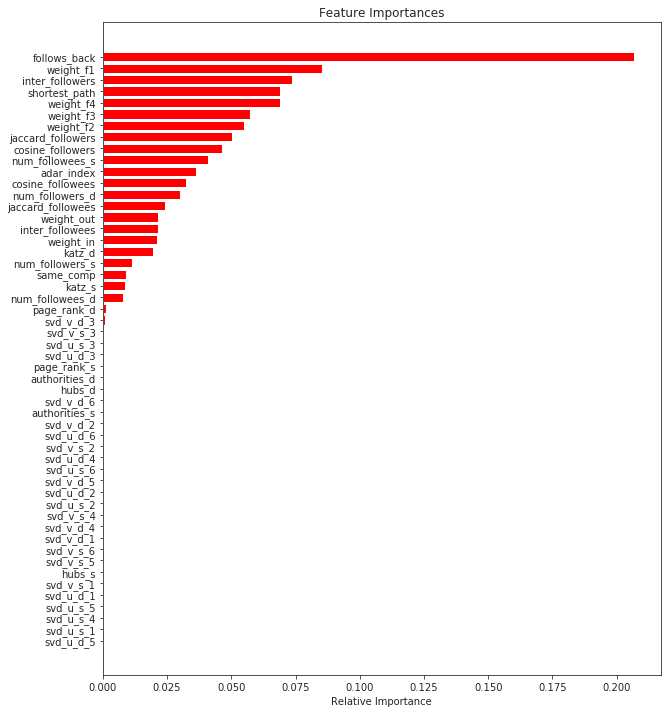

In [101]:
# Feature Importances
importances= clf.feature_importances_
indices = np.argsort(importances)
features = df_final_train.columns
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()


### Preferential Attachment feature

### Preferential Attachement for followers

In [91]:
len(df_final_train.columns)

52

In [92]:
#for train dataset

preferential_followers=[]

for i in range(len(df_final_train['num_followers_s'])):
    preferential_followers.append(df_final_train['num_followers_s'][i] * df_final_train['num_followers_d'][i])

df_final_train['preferential_Attachment_followers']= preferential_followers
df_final_train.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_Attachment_followers
0,0.000000,0.000,0.000000,0.000000,11,6,15,8,0,0,...,1.545079e-13,8.108411e-13,1.719704e-14,-1.355367e-12,4.675097e-13,1.128576e-06,6.616595e-14,9.771027e-13,4.160009e-14,66
1,0.129032,0.000,0.065600,0.000000,22,13,11,0,4,0,...,2.117824e-12,3.687435e-12,3.022959e-13,-8.181062e-13,6.028038e-14,1.066689e-05,2.402134e-13,4.826214e-13,3.142400e-14,286
2,0.466667,0.420,0.074032,0.601722,80,74,84,58,49,42,...,1.535626e-15,1.344008e-14,5.686896e-17,-1.403210e-15,1.562856e-15,1.538390e-10,1.408407e-15,1.234033e-14,5.234822e-17,5920
3,0.000000,0.000,0.000000,0.000000,64,8,73,7,0,0,...,1.171754e-09,1.105390e-09,4.393956e-12,-1.870083e-11,3.760294e-11,1.236179e-09,8.427938e-11,7.854973e-11,4.477570e-13,512
4,0.538462,0.375,0.212121,0.554700,9,11,13,9,7,6,...,3.824854e-16,3.008723e-17,4.585726e-10,-4.353698e-18,4.921965e-18,2.174724e-13,3.902601e-16,3.015683e-17,4.590327e-10,99


In [93]:
#for test dataset

preferential_followers=[]

for i in range(len(df_final_test['num_followers_s'])):
    preferential_followers.append(df_final_test['num_followers_s'][i] * df_final_test['num_followers_d'][i])

df_final_test['preferential_Attachment_followers']= preferential_followers
df_final_test.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_Attachment_followers
0,0.052632,0.000000,0.029161,0.000000,6,14,6,9,1,0,...,2.701517e-12,4.341620e-13,5.535503e-14,-9.993053e-10,5.791346e-10,3.512356e-07,2.486433e-09,2.771145e-09,1.727644e-12,84
1,0.166667,0.125000,0.141421,0.223607,2,5,4,5,1,1,...,2.437688e-11,2.617439e-13,1.431941e-13,-6.782933e-16,4.121851e-13,1.143347e-11,7.866133e-15,3.340809e-14,2.566689e-17,10
2,0.021277,0.020833,0.008019,0.047458,12,36,12,37,1,1,...,1.689338e-12,2.724436e-11,4.505194e-14,-3.016390e-09,1.392944e-09,3.347431e-09,3.973469e-11,4.611220e-10,5.849275e-12,432
3,0.028571,0.000000,0.017010,0.000000,24,12,33,0,1,0,...,3.246943e-10,2.696955e-10,7.448343e-10,-8.877816e-10,4.942912e-12,1.376353e-09,3.879727e-11,3.515460e-10,3.916351e-12,288
4,0.000000,0.000000,0.000000,0.000000,7,3,8,4,0,0,...,1.104148e-13,4.006362e-13,2.668492e-14,-7.243877e-12,2.289052e-12,1.461968e-05,4.394855e-13,2.284175e-12,1.894615e-13,21


### Preferential Attachement for followees

In [94]:
#for train dataset

preferential_followees=[]

for i in range(len(df_final_train['num_followees_s'])):
    preferential_followees.append(df_final_train['num_followees_s'][i] * df_final_train['num_followees_d'][i])

df_final_train['preferential_Attachment_followees']= preferential_followees
df_final_train.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_Attachment_followers,preferential_Attachment_followees
0,0.000000,0.000,0.000000,0.000000,11,6,15,8,0,0,...,8.108411e-13,1.719704e-14,-1.355367e-12,4.675097e-13,1.128576e-06,6.616595e-14,9.771027e-13,4.160009e-14,66,120
1,0.129032,0.000,0.065600,0.000000,22,13,11,0,4,0,...,3.687435e-12,3.022959e-13,-8.181062e-13,6.028038e-14,1.066689e-05,2.402134e-13,4.826214e-13,3.142400e-14,286,0
2,0.466667,0.420,0.074032,0.601722,80,74,84,58,49,42,...,1.344008e-14,5.686896e-17,-1.403210e-15,1.562856e-15,1.538390e-10,1.408407e-15,1.234033e-14,5.234822e-17,5920,4872
3,0.000000,0.000,0.000000,0.000000,64,8,73,7,0,0,...,1.105390e-09,4.393956e-12,-1.870083e-11,3.760294e-11,1.236179e-09,8.427938e-11,7.854973e-11,4.477570e-13,512,511
4,0.538462,0.375,0.212121,0.554700,9,11,13,9,7,6,...,3.008723e-17,4.585726e-10,-4.353698e-18,4.921965e-18,2.174724e-13,3.902601e-16,3.015683e-17,4.590327e-10,99,117


In [95]:
#for test dataset

preferential_followees=[]

for i in range(len(df_final_test['num_followees_s'])):
    preferential_followees.append(df_final_test['num_followees_s'][i] * df_final_test['num_followees_d'][i])

df_final_test['preferential_Attachment_followees']= preferential_followees
df_final_test.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_Attachment_followers,preferential_Attachment_followees
0,0.052632,0.000000,0.029161,0.000000,6,14,6,9,1,0,...,4.341620e-13,5.535503e-14,-9.993053e-10,5.791346e-10,3.512356e-07,2.486433e-09,2.771145e-09,1.727644e-12,84,54
1,0.166667,0.125000,0.141421,0.223607,2,5,4,5,1,1,...,2.617439e-13,1.431941e-13,-6.782933e-16,4.121851e-13,1.143347e-11,7.866133e-15,3.340809e-14,2.566689e-17,10,20
2,0.021277,0.020833,0.008019,0.047458,12,36,12,37,1,1,...,2.724436e-11,4.505194e-14,-3.016390e-09,1.392944e-09,3.347431e-09,3.973469e-11,4.611220e-10,5.849275e-12,432,444
3,0.028571,0.000000,0.017010,0.000000,24,12,33,0,1,0,...,2.696955e-10,7.448343e-10,-8.877816e-10,4.942912e-12,1.376353e-09,3.879727e-11,3.515460e-10,3.916351e-12,288,0
4,0.000000,0.000000,0.000000,0.000000,7,3,8,4,0,0,...,4.006362e-13,2.668492e-14,-7.243877e-12,2.289052e-12,1.461968e-05,4.394855e-13,2.284175e-12,1.894615e-13,21,32


### SVD DOT Feature

# SVD u feature
### Train

In [98]:
svd_dot_u_train=[]

for i in range(len(df_final_train['svd_u_s_1'])):
    svd_dot_u_train.append(df_final_train['svd_u_s_1'][i] * df_final_train['svd_u_d_1'][i] +\
                           df_final_train['svd_u_s_2'][i] * df_final_train['svd_u_d_2'][i] +\
                           df_final_train['svd_u_s_3'][i] * df_final_train['svd_u_d_3'][i] +\
                           df_final_train['svd_u_s_4'][i] * df_final_train['svd_u_d_4'][i] +\
                           df_final_train['svd_u_s_5'][i] * df_final_train['svd_u_d_5'][i] +\
                           df_final_train['svd_u_s_6'][i] * df_final_train['svd_u_d_6'][i]
                           )
    
df_final_train['svd_dot_u']=svd_dot_u_train

# SVD v feature
### Train

In [100]:
svd_dot_v_train=[]

for i in range(len(df_final_train['svd_v_s_1'])):
    svd_dot_v_train.append(df_final_train['svd_v_s_1'][i] * df_final_train['svd_v_d_1'][i] +\
                           df_final_train['svd_v_s_2'][i] * df_final_train['svd_v_d_2'][i] +\
                           df_final_train['svd_v_s_3'][i] * df_final_train['svd_v_d_3'][i] +\
                           df_final_train['svd_v_s_4'][i] * df_final_train['svd_v_d_4'][i] +\
                           df_final_train['svd_v_s_5'][i] * df_final_train['svd_v_d_5'][i] +\
                           df_final_train['svd_v_s_6'][i] * df_final_train['svd_v_d_6'][i]
                           )
    
df_final_train['svd_dot_v']=svd_dot_v_train

In [102]:
df_final_train.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_Attachment_followers,preferential_Attachment_followees,svd_dot_u,svd_dot_v
0,0.000000,0.000,0.000000,0.000000,11,6,15,8,0,0,...,-1.355367e-12,4.675097e-13,1.128576e-06,6.616595e-14,9.771027e-13,4.160009e-14,66,120,1.114956e-11,2.238761e-12
1,0.129032,0.000,0.065600,0.000000,22,13,11,0,4,0,...,-8.181062e-13,6.028038e-14,1.066689e-05,2.402134e-13,4.826214e-13,3.142400e-14,286,0,1.175323e-25,7.660650e-11
2,0.466667,0.420,0.074032,0.601722,80,74,84,58,49,42,...,-1.403210e-15,1.562856e-15,1.538390e-10,1.408407e-15,1.234033e-14,5.234822e-17,5920,4872,5.914169e-20,2.577174e-20
3,0.000000,0.000,0.000000,0.000000,64,8,73,7,0,0,...,-1.870083e-11,3.760294e-11,1.236179e-09,8.427938e-11,7.854973e-11,4.477570e-13,512,511,3.312822e-18,5.230698e-17
4,0.538462,0.375,0.212121,0.554700,9,11,13,9,7,6,...,-4.353698e-18,4.921965e-18,2.174724e-13,3.902601e-16,3.015683e-17,4.590327e-10,99,117,8.491364e-17,2.104999e-19


# SVD u feature
### Test

In [99]:
svd_dot_u_test=[]

for i in range(len(df_final_test['svd_u_s_1'])):
    svd_dot_u_test.append(df_final_test['svd_u_s_1'][i] * df_final_test['svd_u_d_1'][i] +\
                          df_final_test['svd_u_s_2'][i] * df_final_test['svd_u_d_2'][i] +\
                          df_final_test['svd_u_s_3'][i] * df_final_test['svd_u_d_3'][i] +\
                          df_final_test['svd_u_s_4'][i] * df_final_test['svd_u_d_4'][i] +\
                          df_final_test['svd_u_s_5'][i] * df_final_test['svd_u_d_5'][i] +\
                          df_final_test['svd_u_s_6'][i] * df_final_test['svd_u_d_6'][i]
                          )
    
df_final_test['svd_dot_u']=svd_dot_u_test

# SVD v feature
### Test

In [101]:
svd_dot_v_test=[]

for i in range(len(df_final_test['svd_v_s_1'])):
    svd_dot_v_test.append(df_final_test['svd_v_s_1'][i] * df_final_test['svd_v_d_1'][i] +\
                          df_final_test['svd_v_s_2'][i] * df_final_test['svd_v_d_2'][i] +\
                          df_final_test['svd_v_s_3'][i] * df_final_test['svd_v_d_3'][i] +\
                          df_final_test['svd_v_s_4'][i] * df_final_test['svd_v_d_4'][i] +\
                          df_final_test['svd_v_s_5'][i] * df_final_test['svd_v_d_5'][i] +\
                          df_final_test['svd_v_s_6'][i] * df_final_test['svd_v_d_6'][i]
                          )
    
df_final_test['svd_dot_v']=svd_dot_v_test

In [103]:
df_final_test.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_Attachment_followers,preferential_Attachment_followees,svd_dot_u,svd_dot_v
0,0.052632,0.000000,0.029161,0.000000,6,14,6,9,1,0,...,-9.993053e-10,5.791346e-10,3.512356e-07,2.486433e-09,2.771145e-09,1.727644e-12,84,54,8.425226e-20,2.074806e-17
1,0.166667,0.125000,0.141421,0.223607,2,5,4,5,1,1,...,-6.782933e-16,4.121851e-13,1.143347e-11,7.866133e-15,3.340809e-14,2.566689e-17,10,20,6.221815e-25,4.657141e-24
2,0.021277,0.020833,0.008019,0.047458,12,36,12,37,1,1,...,-3.016390e-09,1.392944e-09,3.347431e-09,3.973469e-11,4.611220e-10,5.849275e-12,432,444,7.325176e-17,7.309387e-18
3,0.028571,0.000000,0.017010,0.000000,24,12,33,0,1,0,...,-8.877816e-10,4.942912e-12,1.376353e-09,3.879727e-11,3.515460e-10,3.916351e-12,288,0,-5.276858e-27,1.223503e-17
4,0.000000,0.000000,0.000000,0.000000,7,3,8,4,0,0,...,-7.243877e-12,2.289052e-12,1.461968e-05,4.394855e-13,2.284175e-12,1.894615e-13,21,32,4.472708e-12,5.574956e-12


# Random Forest
### With Preferential Attachment and SVD features

In [104]:
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)
skf = StratifiedKFold(n_splits= 5)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10 ,cv= skf, scoring='f1', random_state=25,
                               return_train_score= True)

rf_random.fit(df_final_train,y_train)

print('mean test scores', rf_random.cv_results_['mean_test_score'])

# return_train_score: boolean, default= False

print('mean train scores', rf_random.cv_results_['mean_train_score'])

mean test scores [0.96233826 0.96225971 0.96007707 0.96189568 0.96379037 0.96108087
 0.96090413 0.96241894 0.96172267 0.95968837]
mean train scores [0.96361484 0.96301524 0.96100192 0.96315617 0.96499005 0.96171303
 0.96154008 0.96316819 0.96279704 0.96034335]


In [105]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [106]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=14, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=28, 
                             min_samples_split=111, min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1, 
                             oob_score=False, random_state=25, verbose=0, warm_start=False)

clf.fit(df_final_train,y_train)

y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9656666261791976
Test f1 score 0.9210320562939797


Train confusion_matrix


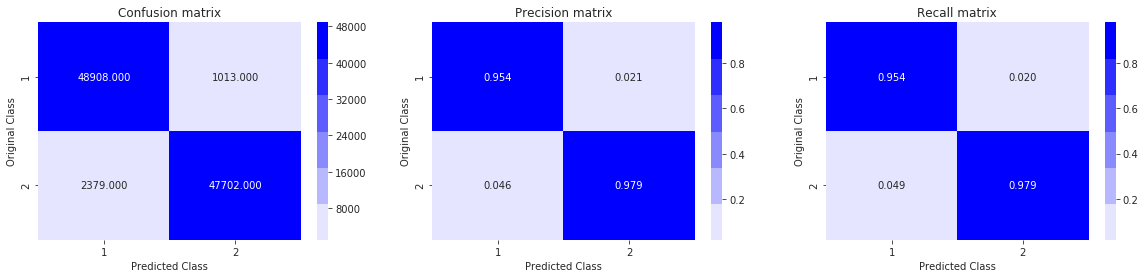

Test confusion_matrix


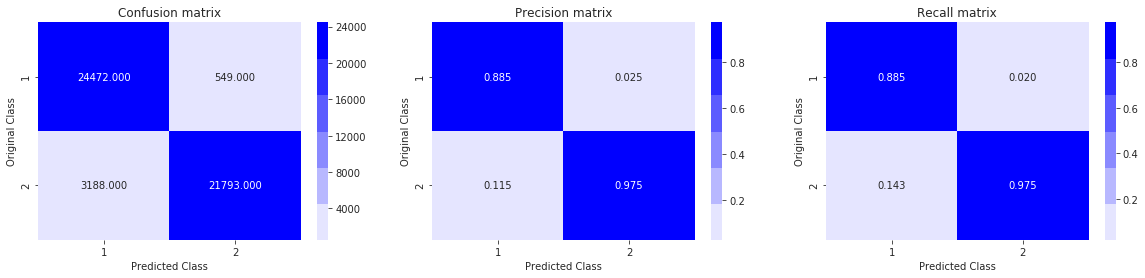

In [109]:
print('Train confusion_matrix')
confusionmatrix(y_train, y_train_pred)

print('Test confusion_matrix')
confusionmatrix(y_test, y_test_pred)

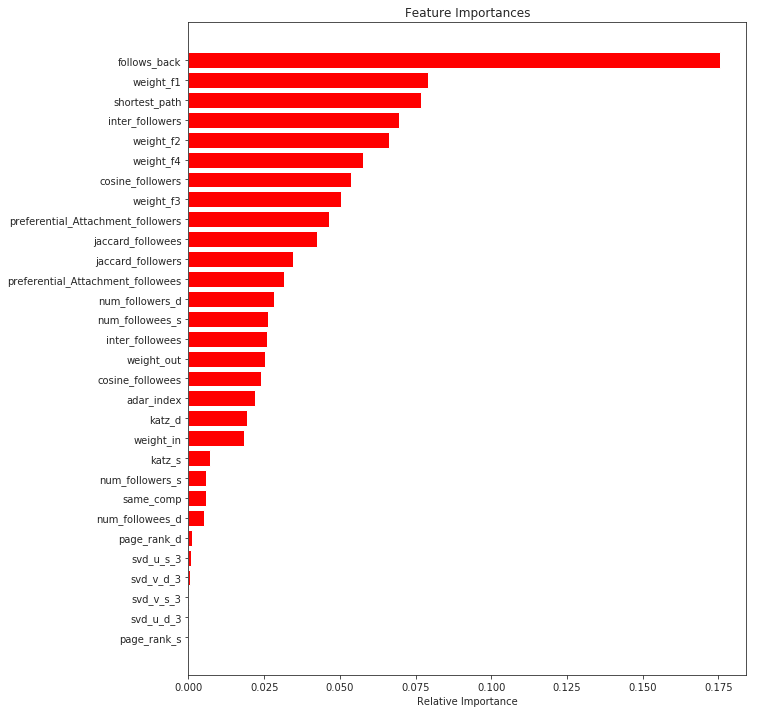

In [110]:
# Feature Importances

importances= clf.feature_importances_
indices = np.argsort(importances)[-30:]
features = df_final_train.columns
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()

# XGBOOST
### With Preferential Attachment and SVD features

In [111]:
from datetime import datetime
start = datetime.now()
parameters = {'n_estimators' : [500, 1000, 2000],
              'objective' : ['binary:logistic', 'binary:hinge', 'reg:squarederror'],
              'eval_metric' : ['logloss', 'error'],
              'max_depth' : [4, 6, 8],
              'eta' : [0.001, 0.02, 0.3],
              'gamma' : [0, 0.1, 5, 10, 15],
              'min_child_weight': [3, 5, 7],
              'reg_alpha' : [0.005, 0.01, 0],
              'reg_lambda' : [0.005, 0.01, 1]}

skf = StratifiedKFold(n_splits= 5)

rscv = RandomizedSearchCV(estimator = xgb.XGBClassifier(n_jobs= -1), param_distributions = parameters, n_jobs= -1, 
                          return_train_score= True, n_iter=10 ,cv= skf, scoring = 'roc_auc')

rscv.fit(df_final_train,y_train)

print('mean test scores', rscv.cv_results_['mean_test_score'])

# return_train_score: boolean, default= False

print('mean train scores', rscv.cv_results_['mean_train_score'])
print()
print('Time taken to complete train linear data: ', datetime.now()-start)

mean test scores [0.98192473 0.99807957 0.99905358 0.98279969 0.97657257 0.9984245
 0.99832342 0.97685208 0.99837079 0.99808177]
mean train scores [0.99990265 0.99841775 1.         0.99445838 0.97798179 0.99894275
 0.99977899 0.9784888  0.99889181 0.99846017]

Time taken to complete train linear data:  1:29:33.399636


In [112]:
print(rscv.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.02,
              eval_metric='error', gamma=0.1, learning_rate=0.1,
              max_delta_step=0, max_depth=8, min_child_weight=7, missing=None,
              n_estimators=1000, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0.005,
              reg_lambda=0.01, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)


In [113]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, 
                        eta=0.02, eval_metric='error', gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=8, 
                        min_child_weight=7, missing=None, n_estimators=1000, n_jobs=-1, nthread=None, random_state=0, 
                        objective='binary:logistic', reg_alpha=0.005, reg_lambda=0.01, seed=None, silent=None, subsample=1)

clf.fit(df_final_train,y_train)

y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.9120392274936556


Train confusion_matrix


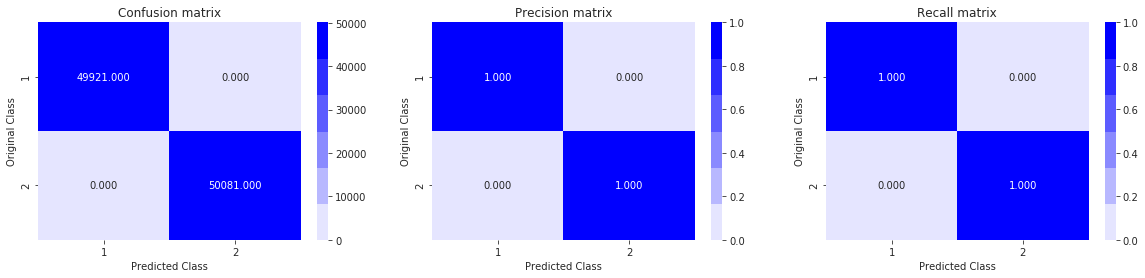

Test confusion_matrix


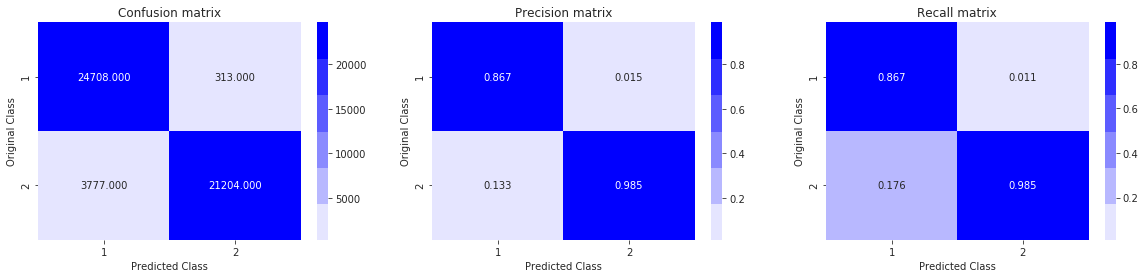

In [114]:
print('Train confusion_matrix')
confusionmatrix(y_train, y_train_pred)

print('Test confusion_matrix')
confusionmatrix(y_test, y_test_pred)

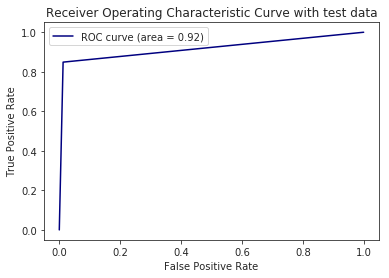

In [115]:
# ROC

fpr, tpr, thresholds = roc_curve(y_test,y_test_pred)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, color='navy', label= 'ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve with test data')
plt.legend()
plt.show()

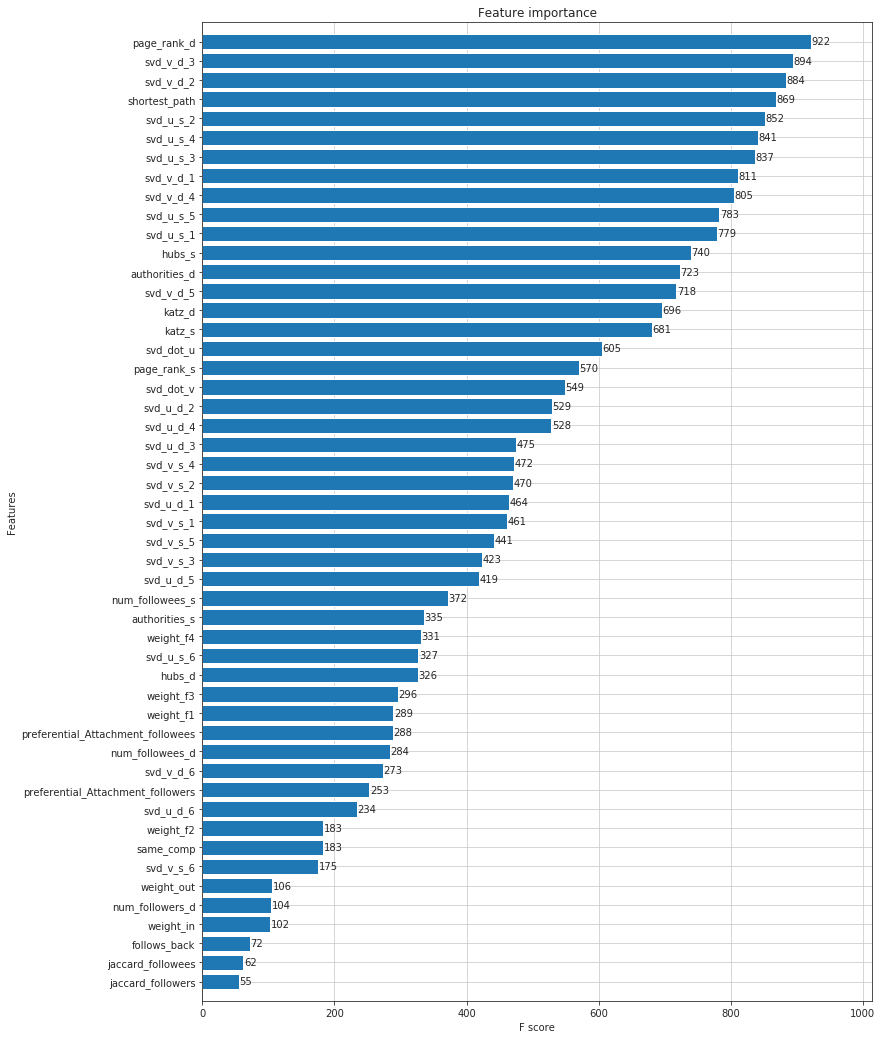

In [116]:
# Feature Importances
# https://stackoverflow.com/a/44990345/10219869

fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf, max_num_features=50, height=0.8, ax=ax)
plt.show()

# Conclusions

In [117]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", 'Hyper param', "Train f1-Score", "Test f1-Score"]
x.add_row(['Random Forest', 'RandomizedSearchCV', '96.6%','92.1%'])
x.add_row(['XGBOOST', 'RandomizedSearchCV', '100%','91.2%'])
print(x)

+---------------+--------------------+----------------+---------------+
|     Model     |    Hyper param     | Train f1-Score | Test f1-Score |
+---------------+--------------------+----------------+---------------+
| Random Forest | RandomizedSearchCV |     96.6%      |     92.1%     |
|    XGBOOST    | RandomizedSearchCV |      100%      |     91.2%     |
+---------------+--------------------+----------------+---------------+
